### Урок 4. Image Segmentation#

### -- Автор: Шенк Евгений Станиславович

### Задание 1. 
Необходимо доработать обучение нейросети, что мы разбирали на уроке.(Посмотрите чего не хватает в процессе обучения и подготовки данных)

Обученные модели весят по 50-150 Mb поэтому загружены на GoogleDisk, ссылка:  
https://drive.google.com/drive/folders/1CGchmpQc8OTQJ4swgj6adB5pYgX53Ovs?usp=sharing

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import time

from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch.nn import functional as F

from sklearn.model_selection import train_test_split

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
def conv_block(in_channels,  out_channels):
    conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=out_channels),
        nn.Conv2d(in_channels, out_channels, kernel_size=3),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=out_channels)
    )
    return conv

## Создание модели

In [4]:
def crop_tensor(target_tensor, tensor):
    target_size = target_tensor.size()[2]
    tensor_size = tensor.size()[2]
    delta = tensor_size - target_size
    delta = delta // 2
    
    return tensor[:,:, delta:tensor_size-delta, delta:tensor_size-delta]

In [5]:
class UNet(nn.Module):

    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes

        # Левая сторона (Путь уменьшения размерности картинки)
        self.down_conv_11 = self.conv_block(in_channels=3, out_channels=64)
        self.down_conv_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_21 = self.conv_block(in_channels=64, out_channels=128)
        self.down_conv_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_31 = self.conv_block(in_channels=128, out_channels=256)
        self.down_conv_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_41 = self.conv_block(in_channels=256, out_channels=512)
        self.down_conv_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        
        # Правая сторона (Путь увеличения размерности картинки)
        self.up_conv_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.up_conv_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_22 = self.conv_block(in_channels=512, out_channels=256)
        self.up_conv_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_32 = self.conv_block(in_channels=256, out_channels=128)
        self.up_conv_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_42 = self.conv_block(in_channels=128, out_channels=64)
        
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
    
    @staticmethod
    def conv_block(in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    @staticmethod
    def crop_tensor(target_tensor, tensor):
        target_size = target_tensor.size()[2]
        tensor_size = tensor.size()[2]
        delta = tensor_size - target_size
        delta = delta // 2

        return tensor[:,:, delta:tensor_size-delta, delta:tensor_size-delta]


    def forward(self, X):
        # Проход по левой стороне
        x1 = self.down_conv_11(X) # [-1, 64, 256, 256]
        x2 = self.down_conv_12(x1) # [-1, 64, 128, 128]
        x3 = self.down_conv_21(x2) # [-1, 128, 128, 128]
        x4 = self.down_conv_22(x3) # [-1, 128, 64, 64]
        x5 = self.down_conv_31(x4) # [-1, 256, 64, 64]
        x6 = self.down_conv_32(x5) # [-1, 256, 32, 32]
        x7 = self.down_conv_41(x6) # [-1, 512, 32, 32]
        x8 = self.down_conv_42(x7) # [-1, 512, 16, 16]
        
        middle_out = self.middle(x8) # [-1, 1024, 16, 16]

        # Проход по правой стороне
        x = self.up_conv_11(middle_out) # [-1, 512, 32, 32]
        y = self.crop_tensor(x, x7)
        x = self.up_conv_12(torch.cat((x, y), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        
        x = self.up_conv_21(x) # [-1, 256, 64, 64]
        y = self.crop_tensor(x, x5)
        x = self.up_conv_22(torch.cat((x, y), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        
        x = self.up_conv_31(x) # [-1, 128, 128, 128]
        y = self.crop_tensor(x, x3)
        x = self.up_conv_32(torch.cat((x, y), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        
        x = self.up_conv_41(x) # [-1, 64, 256, 256]
        y = self.crop_tensor(x, x1)
        x = self.up_conv_42(torch.cat((x, y), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        
        output = self.output(x) # [-1, num_classes, 256, 256]

        return output

## Подготовка датасета

In [6]:
np.unique(plt.imread('../data/dataA/dataA/CameraSeg/02_00_000.png')[:,:,0]*255)

array([ 0.,  1.,  2.,  3.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.],
      dtype=float32)

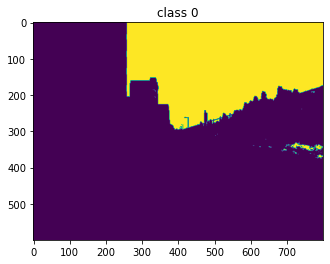

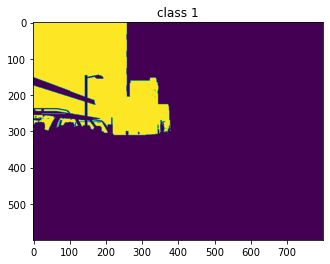

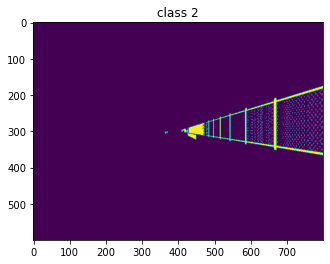

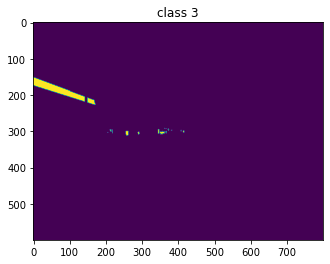

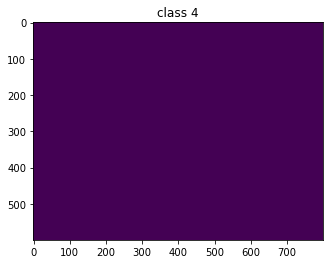

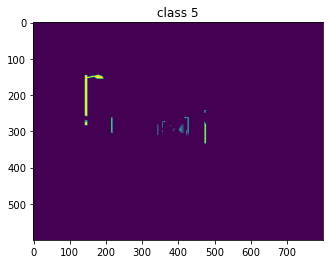

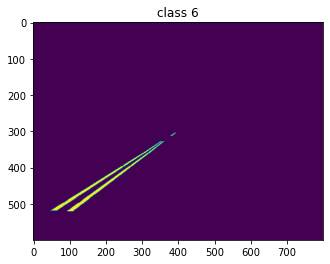

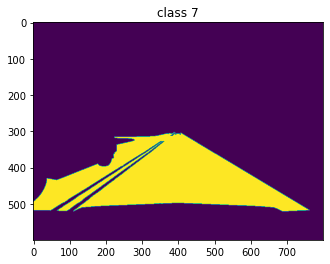

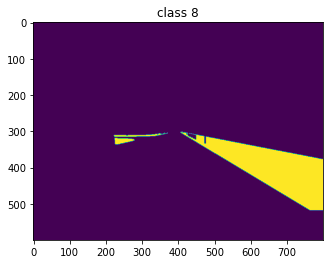

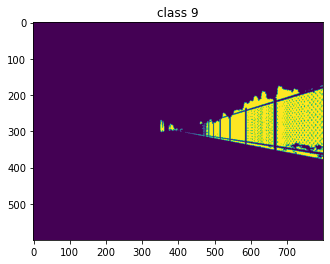

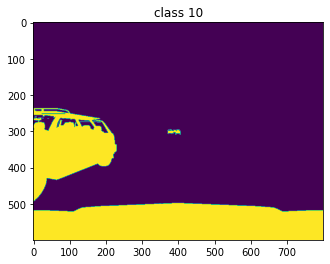

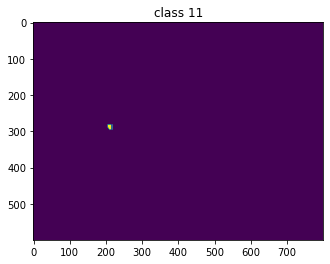

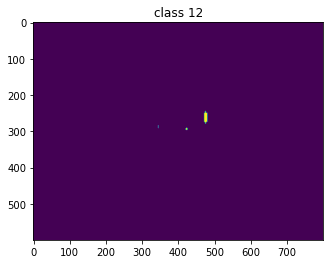

In [7]:
for i in range(13):
    mask = plt.imread('../data/dataA/dataA/CameraSeg/02_00_000.png')*255
    mask = np.where(mask == i, 255, 0)
    mask = mask[:,:,0]
    plt.title(f'class {i}')
    plt.imshow(mask)
    plt.show()

In [8]:
labels = ['Unlabeled','Building','Fence','Other',
                'Pedestrian', 'Pole', 'Roadline', 'Road',
                'Sidewalk', 'Vegetation', 'Car','Wall',
                 'Traffic sign']

In [9]:
cameraRGB = []
cameraSeg = []
for root, dirs, files in os.walk('../data'):
    for name in files:
        f = os.path.join(root, name)
        if 'CameraRGB' in f:
            cameraRGB.append(f)
        elif 'CameraSeg' in f:
            cameraSeg.append(f)
        else:
            break

In [10]:
df = pd.DataFrame({'cameraRGB': cameraRGB, 'cameraSeg': cameraSeg})
# Отсортируем  датафрейм по значениям
df.sort_values(by='cameraRGB',inplace=True)
# Используем функцию,
# лагодаря которой индексация значений 
# будет начинаться с 0.
df.reset_index(drop=True, inplace=True)
# Выведем первые ять значений нашего датафрейма
print(df.head(5))

                                     cameraRGB  \
0  ../data\dataA\dataA\CameraRGB\02_00_000.png   
1  ../data\dataA\dataA\CameraRGB\02_00_001.png   
2  ../data\dataA\dataA\CameraRGB\02_00_010.png   
3  ../data\dataA\dataA\CameraRGB\02_00_011.png   
4  ../data\dataA\dataA\CameraRGB\02_00_020.png   

                                     cameraSeg  
0  ../data\dataA\dataA\CameraSeg\02_00_000.png  
1  ../data\dataA\dataA\CameraSeg\02_00_001.png  
2  ../data\dataA\dataA\CameraSeg\02_00_010.png  
3  ../data\dataA\dataA\CameraSeg\02_00_011.png  
4  ../data\dataA\dataA\CameraSeg\02_00_020.png  


In [11]:
class CustomDatasetFromImages(Dataset):
    def __init__(self, data_info):
        # Подаем наш подготовленный датафрейм
        self.data_info = data_info
        
        # Разделяем датафрейм на rgb картинки 
        self.image_arr = self.data_info.iloc[:,0]
        # и на сегментированные картинки
        self.label_arr = self.data_info.iloc[:,1]
        
        # Количество пар картинка-сегментация
        self.data_len = len(self.data_info.index)
    def __getitem__(self, index):
        # Читаем картинку и сразу же представляем ее в виде numpy-массива 
        # размера 600х800 float-значний
        img = np.asarray(Image.open(self.image_arr[index])).astype('float')
        # Нормализуем изображение в значениях [0,1]
        img = torch.as_tensor(img)/255    
        # 1) unsqueeze - меняет размерность img c (600, 800, 3) -> (1, 600, 800, 3),
        # т.е. оборачивает картинку в батч размером в одну картинку
        # 2) permute - меняет местами измерения , т.е. (1, 600, 800, 3) -> (1, 3, 600, 800)
        img = img.unsqueeze(0).permute(0,3,1,2)
        # Мы используем функцию интерполяции для того,
        # чтобы поменять рамерность картинки с 800х600 на 256х256
        img = F.interpolate(input=img, size=256, align_corners=False, mode='bicubic')
        
        # итаем сегментированную картинку и сразу же представляем ее в виде numpy-массива 
        # размера 600х800 float-значний
        lab = np.asarray(plt.imread(self.label_arr[index]))[:,:,0]*255
        
        # Упаковываем ее в pytorch-тензор и оборачиваем ее в батч из одной каринки,
        # но при этом заполняем 13 каналов масками нужных классов
        # Т.е. там, где например класс автомобилей (10 по счету канал) - все пиксели 0 
        # если не принадлежат классу, и 1 если принадлежат 
        x_out = torch.as_tensor(np.where(lab == 0, 255, 0)).unsqueeze(0)
        for i in range(1, 13):
            mask = np.asarray(plt.imread(self.label_arr[index]))[:,:,0]*255
            mask = np.where(mask == i, 255, 0)
            x = torch.as_tensor(mask).unsqueeze(0)
            x_out =  torch.cat((x_out,x),dim=0)    
        x_out = x_out.float()
        
        lab = x_out.unsqueeze(0)
        # делаем ресайз картинки на 256х256
        lab = F.interpolate(input=lab, size=256, mode='nearest')
        
        
        
        return (img.float(), lab.float())

    def __len__(self):
        return self.data_len

In [12]:
# 70 % в тренировочную выборку, 30 - в тестовую
X_train, X_test = train_test_split(df,test_size=0.3)

# Упорядочиваем индексацию
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

# Оборачиваем каждую выборку в наш кастомный датасет
train_data = CustomDatasetFromImages(X_train)
test_data = CustomDatasetFromImages(X_test)

In [13]:
train_data_loader = DataLoader(train_data,batch_size=1,shuffle=True)
test_data_loader = DataLoader(test_data,batch_size=1,shuffle=False)

## Обучение

In [14]:
learning_rate = 0.001
epochs = 5

In [15]:
Umodel = UNet(num_classes=13).to(device)

In [16]:
optimizer = torch.optim.Adam(Umodel.parameters(), lr=learning_rate)

In [3]:
class SoftDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(SoftDiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth =1
        num = targets.size(0)
        probs = F.sigmoid(logits)
        m1 = probs.view(num, -1)
        m2 = targets.view(num, -1)
        intersection = (m1 * m2)

        score =2. * (intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        score =1 - score.sum() / num
        return score

In [18]:
criterion = SoftDiceLoss()

In [19]:
total_steps = len(train_data_loader)
print(f"{epochs} epochs, {total_steps} total_steps per epoch")

5 epochs, 3500 total_steps per epoch


In [20]:
#Импортируем библиотеку time для расчета, сколько времени у нас уходит на одну эпоху
import time
from torch.autograd import Variable

# Полезная функция для детектирования аномалий в процессе обучения
torch.autograd.set_detect_anomaly(True)

# запускаем главный тренировочный цикл
epoch_losses = []
for epoch in range(epochs):
    
    time1 = time.time()
    running_loss =0.0
    epoch_loss = []
    for batch_idx, (data, labels) in enumerate(train_data_loader):
        
        data, labels = Variable(data), Variable(labels)        
        data = data.cuda()
        labels = labels.cuda()
        
        optimizer.zero_grad()
        
        outputs = Umodel(data[0])

        loss = criterion(outputs, labels[0])
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        if (batch_idx+1) % 300 == 299:
            print(f'Train Epoch: {epoch+1}, Loss: {running_loss/300}')
            time2 = time.time()
            print(f'Spend time for 300 images: {time2-time1} sec')
            time1 = time.time()
            running_loss = 0.0
    print(f'Epoch {epoch+1}, loss: ',np.mean(epoch_loss))
    epoch_losses.append(epoch_loss)

C:\Users\Eugene\anaconda3\lib\site-packages\torch\nn\functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1, Loss: -0.9087819031874339
Spend time for 300 images: 179.30594754219055 sec
Train Epoch: 1, Loss: -0.9486344544092814
Spend time for 300 images: 182.3360185623169 sec
Train Epoch: 1, Loss: -0.9578753077983856
Spend time for 300 images: 187.31807923316956 sec
Train Epoch: 1, Loss: -0.959674680630366
Spend time for 300 images: 190.48971271514893 sec
Train Epoch: 1, Loss: -0.9615253059069315
Spend time for 300 images: 190.49869537353516 sec
Train Epoch: 1, Loss: -0.9620003461837768
Spend time for 300 images: 190.88496351242065 sec
Train Epoch: 1, Loss: -0.9598888345559438
Spend time for 300 images: 190.7447953224182 sec
Train Epoch: 1, Loss: -0.9630002776781718
Spend time for 300 images: 191.02450919151306 sec
Train Epoch: 1, Loss: -0.9639311675230662
Spend time for 300 images: 191.07936644554138 sec
Train Epoch: 1, Loss: -0.963490575949351
Spend time for 300 images: 191.45344257354736 sec
Train Epoch: 1, Loss: -0.9664299197991689
Spend time for 300 images: 191.23919892311

In [21]:
savePATH = './selfLastModel.pth'
#torch.save(Umodel.state_dict(), savePATH)

In [22]:
net=UNet(13)
net.load_state_dict(torch.load(savePATH))

<All keys matched successfully>

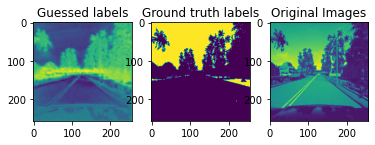

C:\Users\Eugene\anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


<Figure size 432x288 with 0 Axes>

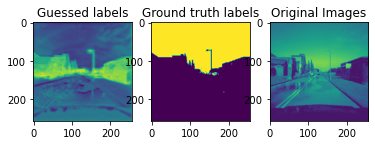

<Figure size 432x288 with 0 Axes>

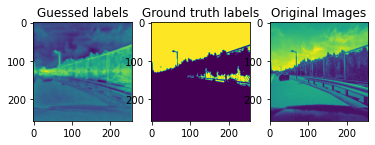

<Figure size 432x288 with 0 Axes>

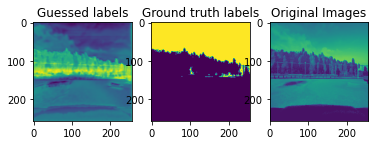

<Figure size 432x288 with 0 Axes>

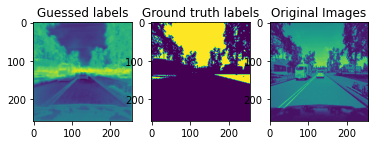

<Figure size 432x288 with 0 Axes>

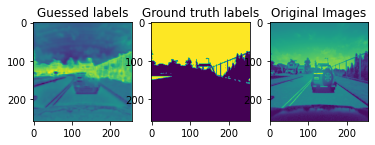

<Figure size 432x288 with 0 Axes>

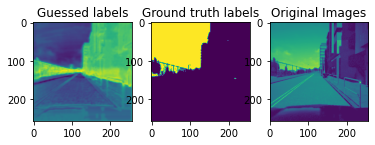

<Figure size 432x288 with 0 Axes>

In [23]:
for i, data in enumerate(test_data_loader):
    images, labels = data
    outputs = net(images[0])
    f, axarr = plt.subplots(1,3)

    axarr[0].imshow(outputs[0].detach().cpu().numpy()[1,:,:])
    axarr[0].set_title('Guessed labels')
    
    axarr[1].imshow(labels[0].detach().cpu().numpy()[0,0,:,:])
    axarr[1].set_title('Ground truth labels')
    
    axarr[2].imshow(images[0].detach().cpu().numpy()[0,0,:,:])
    axarr[2].set_title('Original Images')
    plt.show()
    plt.gcf().show()
    if i>5:
        break

## Задание 2-3.
2. Необходимо скачать и подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples/notebooks для обучения.
3. И затем обучить Модель на выбор из segmentation_models_pytorch

### Выполнение:  
    - Датасет скачан и обработан.  
        Удалены элементы у которых отсутствовал mask или вызывал ошибки
        Из-за того, что обучение шло очень долго, количество элементов в датасете было сокращено до 6000
    - Обучены две модели:  
        Linknet - Resnet101 - 15 epoches  
        Unet - Resnet18 - 50 epoches  
По качеству обе модели получились примерно одинаковые, наверно если 1-ю модель обучить тоже на 50+ эпох, то ее качество будет лучше, но с моим Geforce GTX 970 процесс обучения идет очень долго.  

In [4]:
class CustomDatasetFromImages(Dataset):
    def __init__(self, data_info):
        # Подаем наш подготовленный датафрейм
        self.data_info = data_info
        
        # Разделяем датафрейм на rgb картинки 
        self.image_arr = self.data_info.iloc[:,0]
        # и на сегментированные картинки
        self.label_arr = self.data_info.iloc[:,1]
        
        # Количество пар картинка-сегментация
        self.data_len = len(self.data_info.index)
    def __getitem__(self, index):
        # Читаем картинку и сразу же представляем ее в виде numpy-массива 
        # размера 600х800 float-значний
        img = np.asarray(Image.open(self.image_arr[index])).astype('float')
        # Нормализуем изображение в значениях [0,1]
        img = torch.as_tensor(img)/255    
        # 1) unsqueeze - меняет размерность img c (600, 800, 3) -> (1, 600, 800, 3),
        # т.е. оборачивает картинку в батч размером в одну картинку
        # 2) permute - меняет местами измерения , т.е. (1, 600, 800, 3) -> (1, 3, 600, 800)
        img = img.unsqueeze(0).permute(0,3,1,2)
        # Мы используем функцию интерполяции для того,
        # чтобы поменять рамерность картинки с 800х600 на 256х256
        img = F.interpolate(input=img, size=256, align_corners=False, mode='bicubic')
        
        # итаем сегментированную картинку и сразу же представляем ее в виде numpy-массива 
        # размера 600х800 float-значний
        lab = np.asarray(plt.imread(self.label_arr[index]))[:,:,0]*255
        
        # Упаковываем ее в pytorch-тензор и оборачиваем ее в батч из одной каринки,
        # но при этом заполняем 13 каналов масками нужных классов
        # Т.е. там, где например класс автомобилей (10 по счету канал) - все пиксели 0 
        # если не принадлежат классу, и 1 если принадлежат 
        x_out = torch.as_tensor(np.where(lab == 0, 255, 0)).unsqueeze(0)
        for i in range(1, 2):
            mask = np.asarray(plt.imread(self.label_arr[index]))[:,:,0]*255
            mask = np.where(mask == i, 255, 0)
            x = torch.as_tensor(mask).unsqueeze(0)
            x_out =  torch.cat((x_out,x),dim=0)    
        x_out = x_out.float()
        
        lab = x_out.unsqueeze(0)
        # делаем ресайз картинки на 256х256
        lab = F.interpolate(input=lab, size=256, mode='nearest')
        
        
        
        return (img.float(), lab.float())

    def __len__(self):
        return self.data_len

## Подготовка датасета

In [5]:
images_list = []
mask_list = []
for root, dirs, files in os.walk('../data/set-lipstick-original'):
    for name in files:
        f = os.path.join(root, name)
        if '720p' in f:
            images_list.append(name)
        elif 'mask' in f:
            mask_list.append(name)
        else:
            break

In [6]:
df_list = pd.read_csv('../data/set-lipstick-original/list.csv')
to_drop = df_list.loc[~df_list['mask'].isin(mask_list)].index
df_list.drop(to_drop, inplace = True)

to_drop = df_list[df_list['mask'] == 'mask00000616.png'].index  # Из-за него выдается ошибка
df_list.drop(to_drop, inplace = True)

df_list = df_list.head(6000)
df_list.head(2)

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png


In [7]:
df_list.shape

(6000, 9)

In [8]:
df_lipstick = pd.DataFrame()
df_lipstick['images'] = "../data/set-lipstick-original/720p/" + df_list['filename']
df_lipstick['mask'] = "../data/set-lipstick-original/mask/" + df_list['mask']
# Отсортируем  датафрейм по значениям
#df_lipstick.sort_values(by='images',inplace=True)
# Используем функцию,
# лагодаря которой индексация значений 
# будет начинаться с 0.
df_lipstick.reset_index(drop=True, inplace=True)
# Выведем первые ять значений нашего датафрейма
print(df_lipstick.head(5))

                                              images  \
0  ../data/set-lipstick-original/720p/image000000...   
1  ../data/set-lipstick-original/720p/image000000...   
2  ../data/set-lipstick-original/720p/image000000...   
3  ../data/set-lipstick-original/720p/image000000...   
4  ../data/set-lipstick-original/720p/image000000...   

                                                mask  
0  ../data/set-lipstick-original/mask/mask0000000...  
1  ../data/set-lipstick-original/mask/mask0000000...  
2  ../data/set-lipstick-original/mask/mask0000000...  
3  ../data/set-lipstick-original/mask/mask0000000...  
4  ../data/set-lipstick-original/mask/mask0000000...  


In [9]:
# 70 % в тренировочную выборку, 30 - в тестовую
X_train, X_test = train_test_split(df_lipstick, test_size=0.3)

# Упорядочиваем индексацию
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

# Оборачиваем каждую выборку в наш кастомный датасет
train_data = CustomDatasetFromImages(X_train)
test_data = CustomDatasetFromImages(X_test)

In [10]:
train_data_loader = DataLoader(train_data,batch_size=2,shuffle=True)
test_data_loader = DataLoader(test_data,batch_size=2,shuffle=False)

## Обучение модели

In [12]:
import segmentation_models_pytorch as smp

# создание модели
segmodel = smp.Linknet
segmodel = smp.Linknet('resnet101', classes=2, activation='softmax').to(device)

optimizer = torch.optim.Adam(segmodel.parameters(), lr=1e-3)
criterion = SoftDiceLoss()

In [13]:
epoches = 15
epoch_losses = []

for epoch in range(epoches):  # loop over the dataset multiple times
    running_loss = 0.0
    epoch_loss = []
    t = 0
    time1 = time.time()
    for i, data in enumerate(train_data_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()


        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = segmodel(inputs[0])
        loss = criterion(outputs,labels[0,0,:,:,:])
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        t+=1
        if t % 50 == 49:    # print every 50 mini-batches
            print(f'Epoch: {epoch}, batchcount: {t}, avg. loss for last 50 images: {running_loss/50}')

time2 = time.time()
print(f'Epoch {epoch+1}, loss: ',np.mean(epoch_loss),f' time = {time2-time1} sec')
epoch_losses.append(epoch_loss)

C:\Users\Eugene\anaconda3\lib\site-packages\segmentation_models_pytorch\base\modules.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
C:\Users\Eugene\anaconda3\lib\site-packages\torch\nn\functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 0, batchcount: 49, avg. loss for last 50 images: 0.17328001022338868
Epoch: 0, batchcount: 99, avg. loss for last 50 images: 0.3183076775074005
Epoch: 0, batchcount: 149, avg. loss for last 50 images: 0.458384290933609
Epoch: 0, batchcount: 199, avg. loss for last 50 images: 0.5840956127643585
Epoch: 0, batchcount: 249, avg. loss for last 50 images: 0.7014226627349853
Epoch: 0, batchcount: 299, avg. loss for last 50 images: 0.8254065454006195
Epoch: 0, batchcount: 349, avg. loss for last 50 images: 0.9452756679058075
Epoch: 0, batchcount: 399, avg. loss for last 50 images: 1.0458696389198303
Epoch: 0, batchcount: 449, avg. loss for last 50 images: 1.1583850109577178
Epoch: 0, batchcount: 499, avg. loss for last 50 images: 1.2719173097610474
Epoch: 0, batchcount: 549, avg. loss for last 50 images: 1.4020150542259215
Epoch: 0, batchcount: 599, avg. loss for last 50 images: 1.5057309329509736
Epoch: 0, batchcount: 649, avg. loss for last 50 images: 1.6167312002182006
Epoch: 0, batc

Epoch: 2, batchcount: 1249, avg. loss for last 50 images: 2.7858324897289277
Epoch: 2, batchcount: 1299, avg. loss for last 50 images: 2.904715515375137
Epoch: 2, batchcount: 1349, avg. loss for last 50 images: 3.0150630950927733
Epoch: 2, batchcount: 1399, avg. loss for last 50 images: 3.112453324794769
Epoch: 2, batchcount: 1449, avg. loss for last 50 images: 3.2205290782451628
Epoch: 2, batchcount: 1499, avg. loss for last 50 images: 3.3448264849185945
Epoch: 2, batchcount: 1549, avg. loss for last 50 images: 3.453643938302994
Epoch: 2, batchcount: 1599, avg. loss for last 50 images: 3.563529907464981
Epoch: 2, batchcount: 1649, avg. loss for last 50 images: 3.6847112488746645
Epoch: 2, batchcount: 1699, avg. loss for last 50 images: 3.782791303396225
Epoch: 2, batchcount: 1749, avg. loss for last 50 images: 3.8912559032440184
Epoch: 2, batchcount: 1799, avg. loss for last 50 images: 4.0015019142627715
Epoch: 2, batchcount: 1849, avg. loss for last 50 images: 4.109125926494598
Epoch

Epoch: 5, batchcount: 349, avg. loss for last 50 images: 0.7830189228057861
Epoch: 5, batchcount: 399, avg. loss for last 50 images: 0.8965169990062714
Epoch: 5, batchcount: 449, avg. loss for last 50 images: 1.0050778901576995
Epoch: 5, batchcount: 499, avg. loss for last 50 images: 1.1333429825305938
Epoch: 5, batchcount: 549, avg. loss for last 50 images: 1.249638900756836
Epoch: 5, batchcount: 599, avg. loss for last 50 images: 1.3758781933784485
Epoch: 5, batchcount: 649, avg. loss for last 50 images: 1.465015128850937
Epoch: 5, batchcount: 699, avg. loss for last 50 images: 1.5704798650741578
Epoch: 5, batchcount: 749, avg. loss for last 50 images: 1.6872163319587707
Epoch: 5, batchcount: 799, avg. loss for last 50 images: 1.785163859128952
Epoch: 5, batchcount: 849, avg. loss for last 50 images: 1.901203486919403
Epoch: 5, batchcount: 899, avg. loss for last 50 images: 2.020899112224579
Epoch: 5, batchcount: 949, avg. loss for last 50 images: 2.145452159643173
Epoch: 5, batchcou

Epoch: 7, batchcount: 1549, avg. loss for last 50 images: 3.4401669466495512
Epoch: 7, batchcount: 1599, avg. loss for last 50 images: 3.538608934879303
Epoch: 7, batchcount: 1649, avg. loss for last 50 images: 3.6492131090164186
Epoch: 7, batchcount: 1699, avg. loss for last 50 images: 3.761396051645279
Epoch: 7, batchcount: 1749, avg. loss for last 50 images: 3.8835376012325287
Epoch: 7, batchcount: 1799, avg. loss for last 50 images: 4.005444974899292
Epoch: 7, batchcount: 1849, avg. loss for last 50 images: 4.10921760559082
Epoch: 7, batchcount: 1899, avg. loss for last 50 images: 4.206090369224548
Epoch: 7, batchcount: 1949, avg. loss for last 50 images: 4.3081268632411955
Epoch: 7, batchcount: 1999, avg. loss for last 50 images: 4.428125869035721
Epoch: 7, batchcount: 2049, avg. loss for last 50 images: 4.520824182033539
Epoch: 7, batchcount: 2099, avg. loss for last 50 images: 4.6415771389007565
Epoch: 8, batchcount: 49, avg. loss for last 50 images: 0.10484948754310608
Epoch: 8

Epoch: 10, batchcount: 649, avg. loss for last 50 images: 1.4094593715667725
Epoch: 10, batchcount: 699, avg. loss for last 50 images: 1.519267144203186
Epoch: 10, batchcount: 749, avg. loss for last 50 images: 1.6259166848659516
Epoch: 10, batchcount: 799, avg. loss for last 50 images: 1.7472402834892273
Epoch: 10, batchcount: 849, avg. loss for last 50 images: 1.8564480412006379
Epoch: 10, batchcount: 899, avg. loss for last 50 images: 1.9635066604614257
Epoch: 10, batchcount: 949, avg. loss for last 50 images: 2.0763989269733427
Epoch: 10, batchcount: 999, avg. loss for last 50 images: 2.195480569601059
Epoch: 10, batchcount: 1049, avg. loss for last 50 images: 2.3132243716716765
Epoch: 10, batchcount: 1099, avg. loss for last 50 images: 2.44814026594162
Epoch: 10, batchcount: 1149, avg. loss for last 50 images: 2.5676343560218813
Epoch: 10, batchcount: 1199, avg. loss for last 50 images: 2.680022131204605
Epoch: 10, batchcount: 1249, avg. loss for last 50 images: 2.7874986040592193

Epoch: 12, batchcount: 1799, avg. loss for last 50 images: 3.9496039855480194
Epoch: 12, batchcount: 1849, avg. loss for last 50 images: 4.052559341192246
Epoch: 12, batchcount: 1899, avg. loss for last 50 images: 4.154795898199081
Epoch: 12, batchcount: 1949, avg. loss for last 50 images: 4.244489611387253
Epoch: 12, batchcount: 1999, avg. loss for last 50 images: 4.348405566215515
Epoch: 12, batchcount: 2049, avg. loss for last 50 images: 4.4519197821617125
Epoch: 12, batchcount: 2099, avg. loss for last 50 images: 4.577391245365143
Epoch: 13, batchcount: 49, avg. loss for last 50 images: 0.11135540723800659
Epoch: 13, batchcount: 99, avg. loss for last 50 images: 0.22662553906440736
Epoch: 13, batchcount: 149, avg. loss for last 50 images: 0.34118587017059326
Epoch: 13, batchcount: 199, avg. loss for last 50 images: 0.46757623076438903
Epoch: 13, batchcount: 249, avg. loss for last 50 images: 0.5763145351409912
Epoch: 13, batchcount: 299, avg. loss for last 50 images: 0.681255511045

### Linknet - Resnet101 - 15 epoches

In [22]:
# Linknet - Resnet101
savePATH = './smpModel_2.pth'
#torch.save(segmodel.state_dict(), savePATH)

In [23]:
segmodel = smp.Linknet
segmodel = smp.Linknet('resnet101', classes=2, activation='softmax').to(device)

net=segmodel.to(device)
net.load_state_dict(torch.load(savePATH))

<All keys matched successfully>

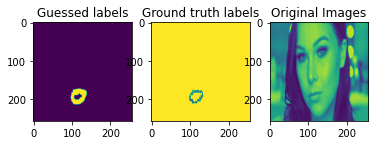

C:\Users\Eugene\anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


<Figure size 432x288 with 0 Axes>

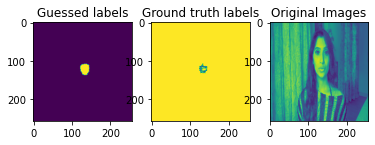

<Figure size 432x288 with 0 Axes>

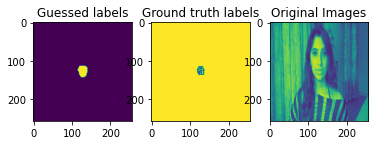

<Figure size 432x288 with 0 Axes>

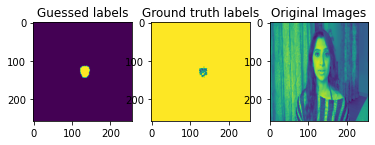

<Figure size 432x288 with 0 Axes>

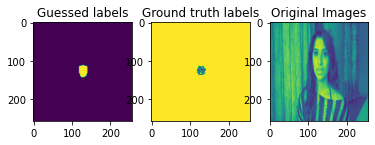

<Figure size 432x288 with 0 Axes>

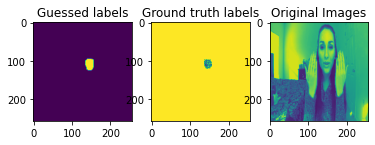

<Figure size 432x288 with 0 Axes>

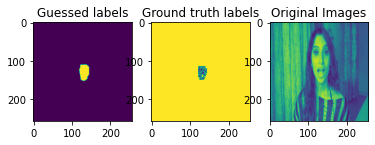

<Figure size 432x288 with 0 Axes>

In [24]:
for i, data in enumerate(test_data_loader):
    images, labels = data
    outputs = net(images[0].to(device))
    f, axarr = plt.subplots(1,3)

    axarr[0].imshow(outputs[0].detach().cpu().numpy()[1,:,:])
    axarr[0].set_title('Guessed labels')
    
    axarr[1].imshow(labels[0].detach().cpu().numpy()[0,0,:,:])
    axarr[1].set_title('Ground truth labels')
    
    axarr[2].imshow(images[0].detach().cpu().numpy()[0,0,:,:])
    axarr[2].set_title('Original Images')
    plt.show()
    plt.gcf().show()
    if i>5:
        break

### Unet - Resnet18 - 50 epoches

In [18]:
# Unet - Resnet18
savePATH = './smpModel.pth'
#torch.save(segmodel.state_dict(), savePATH)

In [20]:
segmodel = smp.Unet()
segmodel = smp.Unet('resnet18', classes=2, activation='softmax').to(device)

net=segmodel.to(device)
net.load_state_dict(torch.load(savePATH))

<All keys matched successfully>

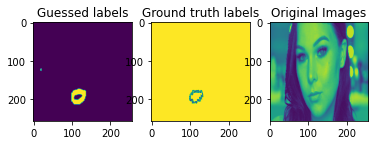

C:\Users\Eugene\anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


<Figure size 432x288 with 0 Axes>

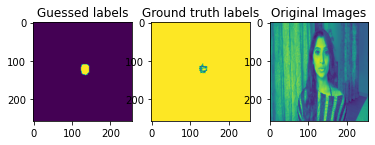

<Figure size 432x288 with 0 Axes>

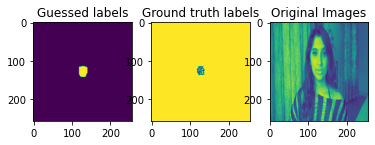

<Figure size 432x288 with 0 Axes>

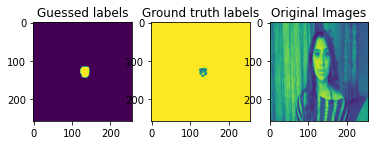

<Figure size 432x288 with 0 Axes>

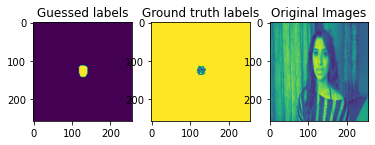

<Figure size 432x288 with 0 Axes>

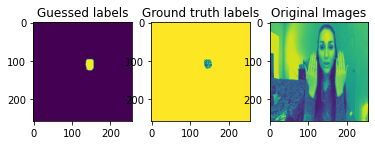

<Figure size 432x288 with 0 Axes>

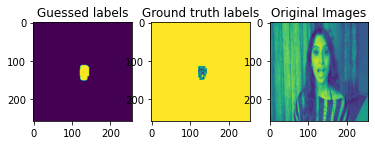

<Figure size 432x288 with 0 Axes>

In [21]:
for i, data in enumerate(test_data_loader):
    images, labels = data
    outputs = net(images[0].to(device))
    f, axarr = plt.subplots(1,3)

    axarr[0].imshow(outputs[0].detach().cpu().numpy()[1,:,:])
    axarr[0].set_title('Guessed labels')
    
    axarr[1].imshow(labels[0].detach().cpu().numpy()[0,0,:,:])
    axarr[1].set_title('Ground truth labels')
    
    axarr[2].imshow(images[0].detach().cpu().numpy()[0,0,:,:])
    axarr[2].set_title('Original Images')
    plt.show()
    plt.gcf().show()
    if i>5:
        break